cuda:0


/home/k_tsubasa/miniconda3/envs/python/lib/python3.9/site-packages/torch/ao/quantization/quantize.py:264: UserWarning: None of the submodule got qconfig applied. Make sure you passed correct configuration through `qconfig_dict` or by assigning the `.qconfig` attribute directly on submodules
  warnings.warn("None of the submodule got qconfig applied. Make sure you "


[ epoch 1 ] loss: 0.156050
[ epoch 2 ] loss: 0.011962
[ epoch 3 ] loss: 0.009392
[ epoch 4 ] loss: 0.008520
[ epoch 5 ] loss: 0.008004
[ epoch 6 ] loss: 0.007679
[ epoch 7 ] loss: 0.007431
[ epoch 8 ] loss: 0.007168
[ epoch 9 ] loss: 0.007091
[ epoch 10 ] loss: 0.006895
[ epoch 11 ] loss: 0.006749
[ epoch 12 ] loss: 0.006715
[ epoch 13 ] loss: 0.006618
[ epoch 14 ] loss: 0.006533
[ epoch 15 ] loss: 0.006470
Finished Training
Loss of the network on the test images: 0.0062350919470191


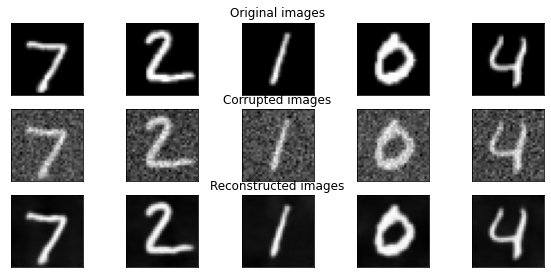

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.quantization import quantize_fx

def add_noise(inputs,noise_factor=0.3):
    noise = inputs+torch.randn_like(inputs)*noise_factor
    return noise

def visualize(model: nn.Module, device, n=5,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        img = testset[i][0].unsqueeze(0).to(device)
        noisy = add_noise(img,noise_factor).to(device) 
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            reconstruct = model(noisy)
        ax = plt.subplot(3,n,i+1)  
        plt.imshow(img.cpu().squeeze().numpy(), 
                   cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2: ax.set_title('Original images')

        ax = plt.subplot(3,n,i+1+n)
        plt.imshow(noisy.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2: ax.set_title('Corrupted images')

        ax = plt.subplot(3,n,i+1+n+n)
        plt.imshow(reconstruct.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2: ax.set_title('Reconstructed images')

    plt.savefig("./images/1.png")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

"""### 1.1 Loading dataset
Load training and test data from the MNIST dataset.
"""
transform = transforms.Compose(
    [
     transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))
    ])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

"""### 1.2 Defining the Neural Network 
Define a simple CNN that classifies MNIST images.
"""
from nnutils import DnCNN
net = DnCNN().to(device)

"""### 1.3 Question: Profiling the Neural Architecture by TorchInfo"""
from torchinfo import summary
summary(net, (4, 1, 32, 32))

### 1.4 Training and Testing the Neural Network
from nnutils import train, test

# QAT
torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(net, inplace=True)
train(net, trainloader, device)
net.eval()
torch.quantization.convert(net, inplace=True)


val_loss = test(net, testloader, None, device, 0)
print('Loss of the network on the test images: {}'.format(val_loss))
torch.save(net.state_dict(), 'dncnn.pt')
visualize(net, device, n=5,noise_factor=0.3)

Loss of the network on the test images: inf


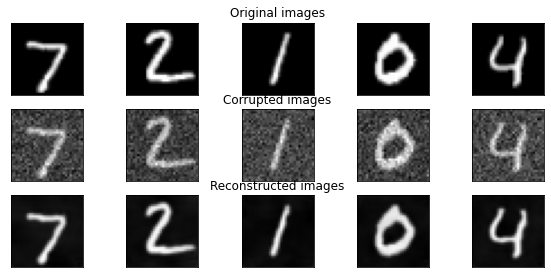

In [2]:
# quantize weight
from nnutils.quantutils import copy_model, quantize_layer_weights

net.load_state_dict(torch.load('dncnn.pt'))
net_q2 = copy_model(net)
quantize_layer_weights(net_q2, device)

val_loss = test(net_q2, testloader, None, device, 1)
print('Loss of the network on the test images: {}'.format(val_loss))
visualize(net_q2, device, n=5,noise_factor=0.3)

Loss of the network on the test images: 0.04105696827173233


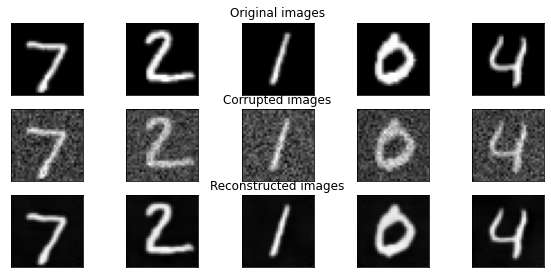

In [3]:
# quantize activations
from nnutils import NetQuantized
from copy import deepcopy

def visualizeActivations(module, input, output):
    if module.profile_activations == True:
        module.inAct = input[0].cpu().view(-1)
        module.outAct = output[0].cpu().view(-1)

net_q3 = copy_model(net)
for name, model in net_q3.named_children():
    model.profile_activations = True
    model.register_forward_hook(visualizeActivations)
net_q3.eval()
with torch.no_grad():
    input = trainset[0][0].unsqueeze(0)
    _ = net_q3(input.to(device))  
for name, model in net_q3.named_children(): model.profile_activations = False 

net_init = copy_model(net_q2)
net_init.input_activations = deepcopy(net_q3.conv_relu_1.inAct)
        
for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    layer_init.inAct = deepcopy(layer_q3.inAct)
    layer_init.outAct = deepcopy(layer_q3.outAct)

net_quantized = NetQuantized(net_init)

val_loss = test(net_quantized, testloader, None, device, 1)
print('Loss of the network on the test images: {}'.format(val_loss))
torch.save(net_quantized.state_dict(), 'dncnn.pt')
visualize(net_quantized, device, n=5,noise_factor=0.3)

In [4]:
inference_model = copy_model(net_quantized)
index = range(1)
import os 
import zipfile
# It is easier to download all the files zipped.
zf = zipfile.ZipFile('parameters.zip', 'w', zipfile.ZIP_DEFLATED)
if not os.path.exists('./activations'):
    os.mkdir('./activations')
for ind in range(1):
    if not os.path.exists('./activations/img{}'.format(ind)):
        os.mkdir('./activations/img{}'.format(ind))

    for name, model in inference_model.named_children():
        model.profile_activations = True
        model.register_forward_hook(visualizeActivations)
    input, label = testset[index[ind]]
    output = inference_model(input.unsqueeze(0).to(device))
    for name, model in inference_model.named_children(): model.profile_activations = False 
    
    np.savetxt('./activations/img{}/input.csv'.format(ind), input.cpu().data.numpy().reshape(-1), delimiter=',')
    np.savetxt('./activations/img{}/output.csv'.format(ind), output.cpu().data.numpy().reshape(-1).astype(int), delimiter=',')
    zf.write('./activations/img{}/input.csv'.format(ind))
    zf.write('./activations/img{}/output.csv'.format(ind))
    
    opDict = {
        'conv_relu_1': (inference_model.conv_relu_1.inAct, inference_model.conv_relu_1.outAct),
        'conv_relu_2': (inference_model.conv_relu_2.inAct, inference_model.conv_relu_2.outAct),
        'conv_relu_3': (inference_model.conv_relu_3.inAct, inference_model.conv_relu_3.outAct),
        'conv_relu_4': (inference_model.conv_relu_4.inAct, inference_model.conv_relu_4.outAct),
        'conv_relu_5': (inference_model.conv_relu_5.inAct, inference_model.conv_relu_5.outAct),
        'conv_relu_6': (inference_model.conv_relu_6.inAct, inference_model.conv_relu_6.outAct),
        'conv_7': (inference_model.conv_7.inAct, inference_model.conv_7.outAct)
    }
    for key in opDict:
        if not os.path.exists('./activations/img{}/{}'.format(ind, key)):
            os.mkdir('./activations/img{}/{}'.format(ind, key))
#         print(opDict[key][0].cpu().data.numpy().reshape(-1).astype(int))
#         print(opDict[key][1].cpu().data.numpy().reshape(-1).astype(int))
        np.savetxt('./activations/img{}/{}/input.csv'.format(ind, key), opDict[key][0].cpu().data.numpy().reshape(-1).astype(int), delimiter=',')
        np.savetxt('./activations/img{}/{}/output.csv'.format(ind, key), opDict[key][1].cpu().data.numpy().reshape(-1).astype(int), delimiter=',')
        zf.write('./activations/img{}/{}/input.csv'.format(ind, key))
        zf.write('./activations/img{}/{}/output.csv'.format(ind, key))

In [5]:
if not os.path.exists('./weights'):
    os.mkdir('./weights')
for name, weights in inference_model.state_dict().items():
    print(name, 'with shape:' , weights.shape)
#     print(weights.cpu().numpy().reshape(-1).astype(int))
    np.savetxt('./weights/%s.csv' %(name) , weights.cpu().numpy().reshape(-1).astype(int), delimiter=',')
    zf.write('./weights/%s.csv' %(name))

conv_relu_1.conv.weight with shape: torch.Size([16, 1, 3, 3])
conv_relu_2.conv.weight with shape: torch.Size([16, 16, 3, 3])
conv_relu_3.conv.weight with shape: torch.Size([16, 16, 3, 3])
conv_relu_4.conv.weight with shape: torch.Size([16, 16, 3, 3])
conv_relu_5.conv.weight with shape: torch.Size([16, 16, 3, 3])
conv_relu_6.conv.weight with shape: torch.Size([16, 16, 3, 3])
conv_7.conv.weight with shape: torch.Size([1, 16, 3, 3])


In [6]:
import json
scales = {'input_scale':inference_model.input_scale.item(), 
          'conv_relu_1_output_scale': inference_model.conv_relu_1.output_scale.item(), 
          'conv_relu_2_output_scale':inference_model.conv_relu_2.output_scale.item(),
          'conv_relu_3_output_scale' :inference_model.conv_relu_3.output_scale.item(), 
          'conv_relu_4_output_scale':inference_model.conv_relu_4.output_scale.item(), 
          'conv_relu_5_output_scale':inference_model.conv_relu_5.output_scale.item(),
          'conv_relu_6_output_scale':inference_model.conv_relu_6.output_scale.item(),
          'conv_7_output_scale':inference_model.conv_7.output_scale.item()}
print(scales)
with open('scale.json', 'w', newline='') as jsonfile:
    json.dump(scales, jsonfile)

zf.write('./scale.json')

{'input_scale': 127.5, 'conv_relu_1_output_scale': 0.0021333142649382353, 'conv_relu_2_output_scale': 0.0021707250270992517, 'conv_relu_3_output_scale': 0.002170056104660034, 'conv_relu_4_output_scale': 0.003054246539250016, 'conv_relu_5_output_scale': 0.0019661681726574898, 'conv_relu_6_output_scale': 0.0035522847902029753, 'conv_7_output_scale': 0.003984095528721809}


In [7]:
import json
scale_hw = {
    'input_scale': int(round(inference_model.input_scale.item())), 
    'conv_relu_1_output_scale': int(round(inference_model.conv_relu_1.output_scale.item()*(2**16))), 
    'conv_relu_2_output_scale': int(round(inference_model.conv_relu_2.output_scale.item()*(2**16))),
    'conv_relu_3_output_scale': int(round(inference_model.conv_relu_3.output_scale.item()*(2**16))), 
    'conv_relu_4_output_scale': int(round(inference_model.conv_relu_4.output_scale.item()*(2**16))), 
    'conv_relu_5_output_scale': int(round(inference_model.conv_relu_5.output_scale.item()*(2**16))),
    'conv_relu_6_output_scale': int(round(inference_model.conv_relu_6.output_scale.item()*(2**16))), 
    'conv_7_output_scale': int(round(inference_model.conv_7.output_scale.item()*(2**16)))
}
print(scale_hw)
with open('scale_hw.json', 'w', newline='') as jsonfile:
    json.dump(scale_hw, jsonfile)

zf.write('./scale_hw.json')

{'input_scale': 128, 'conv_relu_1_output_scale': 140, 'conv_relu_2_output_scale': 142, 'conv_relu_3_output_scale': 142, 'conv_relu_4_output_scale': 200, 'conv_relu_5_output_scale': 129, 'conv_relu_6_output_scale': 233, 'conv_7_output_scale': 261}
